In [3]:
from datasets import load_dataset

ds = load_dataset("onurSakar/GYM-Exercise")

In [4]:

# # Chatbot Coach Sportif en Français avec mT5-small (FP16, batch_size ≤ 4)
#
# Ce notebook présente le fine‑tuning de **mT5-small** en précision mixte (FP16) avec un batch size maximal de 4.
# Optimisé pour un GPU 3060 Laptop (6 Go VRAM) 


# 1) Installation et imports
%pip install transformers datasets evaluate accelerate

from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch

#

Note: you may need to restart the kernel to use updated packages.


In [5]:



#2) Chargement et exploration des données

# Chargement du split 'train' et découpes en train/validation
raw = load_dataset("onurSakar/GYM-Exercise")['train']
cols = ['EXERCISE_NAME','EXERCISE_TYPE','MUSCLES_PRIMARY','EQUIPMENT']
raw = raw.remove_columns([c for c in raw.column_names if c not in cols])
split = raw.train_test_split(train_size=500, test_size=100, seed=42)
datasets = DatasetDict({
    'train': split['train'],
    'validation': split['test'],
})
print(datasets)





DatasetDict({
    train: Dataset({
        features: [],
        num_rows: 0
    })
    validation: Dataset({
        features: [],
        num_rows: 0
    })
})


In [6]:

#Pré‑traitement & Tokenisation

model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_length, max_target_length = 128, 64

def preprocess_examples(examples):
    inputs = [
        f"Question: Explique l'exercice {name} pour cibler {muscles}. Type: {type_}, équipement: {eq}."
        for name, muscles, type_, eq in zip(
            examples['EXERCISE_NAME'], examples['MUSCLES_PRIMARY'],
            examples['EXERCISE_TYPE'], examples['EQUIPMENT']
        )
    ]
    targets = [f"Réponse: Voici comment réaliser {name}..." for name in examples['EXERCISE_NAME']]

    tokenized_inputs = tokenizer(
        inputs, max_length=max_input_length, truncation=True, padding='max_length'
    )
    tokenized_targets = tokenizer(
        targets, max_length=max_target_length, truncation=True, padding='max_length'
    )
    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    return tokenized_inputs

# Map train
tokenized_train = datasets['train'].map(
    preprocess_examples,
    batched=True,
)
# Map validation
tokenized_val = datasets['validation'].map(
    preprocess_examples,
    batched=True,
)

# Supprimer colonnes d'origine
tokenized_train = tokenized_train.remove_columns(cols)
tokenized_val   = tokenized_val.remove_columns(cols)

# Conversion en format PyTorch
tokenized_train.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
tokenized_val.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# Reconstruction du DatasetDict tokenisé
from datasets import DatasetDict as _DatasetDict
tokenized = _DatasetDict({
    'train': tokenized_train,
    'validation': tokenized_val,
})

# Data collator pour Seq2Seq
from transformers import DataCollatorForSeq2Seq as _DataCollatorForSeq2Seq
data_collator = _DataCollatorForSeq2Seq(tokenizer, model=None)
tokenized = DatasetDict({
    'train': tokenized_train,
    'validation': tokenized_val,
})

# Data collator pour Seq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=None, return_tensors='pt')(tokenizer, model=None, return_tensors='pt')

# %% [markdown]
# ## 4) Fine‑tuning mT5-small

model = MT5ForConditionalGeneration.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",   # dossier de checkpoints
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    predict_with_generate=True,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=200,
    do_eval=True,
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,      # conserver toutes les colonnes utiles
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized['train'],  # assurez-vous que ces splits existent
    eval_dataset=tokenized['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Lancement de l'entraînement
trainer.train()

# %% [markdown]
# ## 5) Inference : exemples de génération

prompts = [
    "Question: Explique l'exercice Bench Press pour cibler pectoraux. Type: Strength, équipement: Barbell.",
    "Question: Décris l'exercice Squat pour les quadriceps. Type: Strength, équipement: Bodyweight.",
]
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_length)
inputs = {k: v.to(device) for k, v in inputs.items()}

outputs = model.generate(**inputs, max_length=64, num_beams=4)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

# %% [markdown]
# ## 6) Évaluation

import math
from datasets import load_metric
metric = load_metric("perplexity", module_type="metrics")

results = trainer.predict(tokenized['validation'])
perplexity = math.exp(results.metrics['eval_loss'])
print(f"Perplexité (valid): {perplexity:.2f}")

# Prompt → attendu vs généré
for ex in datasets['validation'].shuffle(seed=1).select(range(5)):
    prompt = f"Question: Explique l'exercice {ex['EXERCISE_NAME']} pour cibler {ex['MUSCLES_PRIMARY']}."
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    gen_ids = model.generate(input_ids, max_length=64)
    print("\nPrompt:", prompt)
    print("Attendu:", f"Réponse: Voici comment réaliser {ex['EXERCISE_NAME']}...")
    print("Généré:", tokenizer.decode(gen_ids[0], skip_special_tokens=True))

# %% [markdown]
# ## 7) Visualisation des métriques

import matplotlib.pyplot as plt
logs = trainer.state.log_history
train_loss = [x['loss'] for x in logs if 'loss' in x and x.get('epoch')]
eval_loss  = [x['eval_loss'] for x in logs if 'eval_loss' in x]
epochs     = sorted(set([x['epoch'] for x in logs if 'loss' in x]))
eval_epochs= sorted(set([x['epoch'] for x in logs if 'eval_loss' in x]))

plt.figure()
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(eval_epochs, eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.show()


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ValueError: Column name ['MUSCLES_PRIMARY', 'EQUIPMENT', 'EXERCISE_TYPE', 'EXERCISE_NAME'] not in the dataset. Current columns in the dataset: []

In [11]:


# %% [markdown]
# ## 3) Pré‑traitement & Tokenisation

model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_length, max_target_length = 128, 64

def preprocess_examples(examples):
    inputs = [
        f"Question: Explique l'exercice {name} pour cibler {muscles}. Type: {type_}, équipement: {eq}."
        for name, muscles, type_, eq in zip(
            examples['EXERCISE_NAME'], examples['MUSCLES_PRIMARY'],
            examples['EXERCISE_TYPE'], examples['EQUIPMENT']
        )
    ]
    targets = [f"Réponse: Voici comment réaliser {name}..." for name in examples['EXERCISE_NAME']]

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized = datasets.map(
    preprocess_examples,
    batched=True,
    remove_columns=datasets['train'].column_names
)
# Convertir en format PyTorch pour le DataLoader
tokenized.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

data_collator = DataCollatorForSeq2Seq(tokenizer, model=None, return_tensors='pt')



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


ValueError: Columns ['attention_mask', 'input_ids', 'labels'] not in the dataset. Current columns in the dataset: []

In [ ]:


# %% [markdown]
# ## 4) Fine‑tuning mT5-small

model = MT5ForConditionalGeneration.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",   # dossier de checkpoints
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    predict_with_generate=True,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=200,
    do_eval=True,
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,      # conserver toutes les colonnes utiles
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized['train'],  # assurez-vous que ces splits existent
    eval_dataset=tokenized['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Lancement de l'entraînement
trainer.train()

# %% [markdown]
# ## 5) Inference : exemples de génération

prompts = [
    "Question: Explique l'exercice Bench Press pour cibler pectoraux. Type: Strength, équipement: Barbell.",
    "Question: Décris l'exercice Squat pour les quadriceps. Type: Strength, équipement: Bodyweight.",
]
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_length)
inputs = {k: v.to(device) for k, v in inputs.items()}

outputs = model.generate(**inputs, max_length=64, num_beams=4)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))




In [ ]:


# %% [markdown]
# ## 6) Évaluation

import math
from datasets import load_metric
metric = load_metric("perplexity", module_type="metrics")

results = trainer.predict(tokenized['validation'])
perplexity = math.exp(results.metrics['eval_loss'])
print(f"Perplexité (valid): {perplexity:.2f}")

# Prompt → attendu vs généré
for ex in datasets['validation'].shuffle(seed=1).select(range(5)):
    prompt = f"Question: Explique l'exercice {ex['EXERCISE_NAME']} pour cibler {ex['MUSCLES_PRIMARY']}."
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    gen_ids = model.generate(input_ids, max_length=64)
    print("\nPrompt:", prompt)
    print("Attendu:", f"Réponse: Voici comment réaliser {ex['EXERCISE_NAME']}...")
    print("Généré:", tokenizer.decode(gen_ids[0], skip_special_tokens=True))

# %% [markdown]
# ## 7) Visualisation des métriques

import matplotlib.pyplot as plt
logs = trainer.state.log_history
train_loss = [x['loss'] for x in logs if 'loss' in x and x.get('epoch')]
eval_loss  = [x['eval_loss'] for x in logs if 'eval_loss' in x]
epochs     = sorted(set([x['epoch'] for x in logs if 'loss' in x]))
eval_epochs= sorted(set([x['epoch'] for x in logs if 'eval_loss' in x]))

plt.figure()
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(eval_epochs, eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.show()


In [15]:
# %% [markdown]
# # Chatbot Coach Sportif en Français avec **mT5‑small** (FP16, batch ≤ 4)
#
# Ce notebook montre comment fine‑tuner **google/mt5‑small** pour générer des réponses de coaching sportif en français à partir du dataset **onurSakar/GYM‑Exercise**.
# Paramètres pensés pour un GPU RTX 3060 Laptop (6 Go VRAM).
#
# **Plan :**
# 1. Installation & imports  
# 2. Préparation du dataset (split train/validation)  
# 3. Tokenisation  
# 4. Fine‑tuning  
# 5. Inference & évaluation  
# 6. Visualisation des métriques

# %%
# 1) Installation et imports
%pip install -q transformers datasets evaluate accelerate

from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch, math, random

# %% [markdown]
# ## 2) Chargement et découpe des données

# On ne dispose que d'un split "train" → on crée validation manuellement
raw = load_dataset("onurSakar/GYM-Exercise")['train']
cols_keep = ["EXERCISE_NAME","EXERCISE_TYPE","MUSCLES_PRIMARY","EQUIPMENT"]
raw = raw.remove_columns([c for c in raw.column_names if c not in cols_keep])

# Sous‑échantillonnage : 600 exemples (500 train / 100 val) pour une démo rapide
raw = raw.shuffle(seed=42).select(range(600))
split = raw.train_test_split(test_size=100, seed=42)
datasets = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
})
print(datasets)

# %% [markdown]
# ## 3) Pré‑traitement & tokenisation

model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_len, max_target_len = 128, 64

prompt_tpl  = (
    "Question : Explique l'exercice {name} pour cibler {muscles}. "
    "Type : {type}, équipement : {eq}."
)
answer_tpl  = "Réponse : Voici comment réaliser {name} :"


def preprocess(batch):
    inputs   = [prompt_tpl.format(name=n, muscles=m, type=t, eq=e)
                for n, m, t, e in zip(batch["EXERCISE_NAME"], batch["MUSCLES_PRIMARY"],
                                      batch["EXERCISE_TYPE"], batch["EQUIPMENT"])]
    targets  = [answer_tpl.format(name=n) for n in batch["EXERCISE_NAME"]]

    model_inputs = tokenizer(inputs, max_length=max_input_len, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_len, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenisation des deux splits
print("Tokenisation…")
train_tok = datasets["train"].map(preprocess, batched=True, remove_columns=cols_keep)
val_tok   = datasets["validation"].map(preprocess, batched=True, remove_columns=cols_keep)

# Conversion en tensors PyTorch
train_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
val_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

tokenized = DatasetDict({"train": train_tok, "validation": val_tok})
print(tokenized)

# %% [markdown]
# ## 4) Fine‑tuning

model = MT5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    learning_rate=5e-5,
    weight_decay=0.01,
    predict_with_generate=True,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=50,
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# %% [markdown]
# ## 5) Inference rapide

prompts = [
    "Question : Explique l'exercice Bench Press pour cibler pectoraux. Type : Strength, équipement : Barbell.",
    "Question : Décris l'exercice Squat pour les quadriceps. Type : Strength, équipement : Bodyweight.",
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_len).to(device)
outputs = model.generate(**inputs, max_length=64, num_beams=4)
print("\n\nGénérations :")
print(*tokenizer.batch_decode(outputs, skip_special_tokens=True), sep="\n")

# %% [markdown]
# ## 6) Évaluation & visualisation

import matplotlib.pyplot as plt

# Perplexité de validation
val_loss = trainer.evaluate()["eval_loss"]
perplexity = math.exp(val_loss)
print(f"Perplexité validation : {perplexity:.2f}")

# Courbes de loss
train_logs = [l for l in trainer.state.log_history if "loss" in l and l.get("epoch") is not None]
train_epochs = [l["epoch"] for l in train_logs]
train_losses = [l["loss"] for l in train_logs]

eval_logs = [l for l in trainer.state.log_history if "eval_loss" in l]
eval_epochs = [l["epoch"] for l in eval_logs]
eval_losses = [l["eval_loss"] for l in eval_logs]

plt.figure()
plt.plot(train_epochs, train_losses, label="Train loss")
plt.plot(eval_epochs, eval_losses, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()
plt.show()


Note: you may need to restart the kernel to use updated packages.
DatasetDict({
    train: Dataset({
        features: [],
        num_rows: 0
    })
    validation: Dataset({
        features: [],
        num_rows: 0
    })
})


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


Tokenisation…


ValueError: Column name ['EQUIPMENT', 'EXERCISE_TYPE', 'EXERCISE_NAME', 'MUSCLES_PRIMARY'] not in the dataset. Current columns in the dataset: []

In [17]:
# %% [markdown]
# # Chatbot Coach Sportif en Français avec **mT5‑small** (FP16, batch ≤ 4)
#
# Ce notebook montre comment fine‑tuner **google/mt5‑small** pour générer des réponses de coaching sportif en français à partir du dataset **onurSakar/GYM‑Exercise**.
# Paramètres pensés pour un GPU RTX 3060 Laptop (6 Go VRAM).
#
# **Plan :**
# 1. Installation & imports  
# 2. Préparation du dataset (split train/validation)  
# 3. Tokenisation  
# 4. Fine‑tuning  
# 5. Inference & évaluation  
# 6. Visualisation des métriques

# %%
# 1) Installation et imports


from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch, math, random

# %% [markdown]
# ## 2) Chargement et découpe des données

# On ne dispose que d'un split "train" → on crée validation manuellement
raw = load_dataset("onurSakar/GYM-Exercise")['train']
cols_keep = ["EXERCISE_NAME","EXERCISE_TYPE","MUSCLES_PRIMARY","EQUIPMENT"]
raw = raw.remove_columns([c for c in raw.column_names if c not in cols_keep])

# Sous‑échantillonnage : 600 exemples (500 train / 100 val) pour une démo rapide
raw = raw.shuffle(seed=42).select(range(600))
split = raw.train_test_split(test_size=100, seed=42)
datasets = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
})
print(datasets)

# %% [markdown]
# ## 3) Pré‑traitement & tokenisation

# On parse la colonne 'text' pour extraire question et réponse
import re

def split_instruction_response(example):
    text = example['text']
    # Séparer instruction et réponse
    parts = text.split("[/INST]")
    if len(parts) != 2:
        return {"input_text": "", "target_text": ""}
    instr_part, ans_part = parts
    # Extraire la question après la balise de fin du SYS
    question = instr_part.split("<</SYS>>")[-1].strip()
    # Nettoyer la réponse (enlever balises)</n    answer = ans_part.replace("</s>", "").strip()
    return {"input_text": question, "target_text": answer}

# Appliquer le split sur les datasets bruts
split_train = datasets['train'].map(split_instruction_response)
split_val   = datasets['validation'].map(split_instruction_response)

# Tokenisation
model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_len, max_target_len = 128, 64

def preprocess(batch):
    # Tokenize inputs
    enc = tokenizer(batch['input_text'], max_length=max_input_len,
                    truncation=True, padding='max_length')
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['target_text'], max_length=max_target_len,
                           truncation=True, padding='max_length')
    enc['labels'] = labels['input_ids']
    return enc

train_tok = split_train.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])
val_tok   = split_val.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])

# Conversion en format PyTorch
train_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
val_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

tokenized = DatasetDict({'train': train_tok, 'validation': val_tok})
print(tokenized)

## 4) Fine‑tuning

model = MT5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    learning_rate=5e-5,
    weight_decay=0.01,
    predict_with_generate=True,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=50,
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# %% [markdown]
# ## 5) Inference rapide

prompts = [
    "Question : Explique l'exercice Bench Press pour cibler pectoraux. Type : Strength, équipement : Barbell.",
    "Question : Décris l'exercice Squat pour les quadriceps. Type : Strength, équipement : Bodyweight.",
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_len).to(device)
outputs = model.generate(**inputs, max_length=64, num_beams=4)
print("\n\nGénérations :")
print(*tokenizer.batch_decode(outputs, skip_special_tokens=True), sep="\n")

# %% [markdown]
# ## 6) Évaluation & visualisation

import matplotlib.pyplot as plt

# Perplexité de validation
val_loss = trainer.evaluate()["eval_loss"]
perplexity = math.exp(val_loss)
print(f"Perplexité validation : {perplexity:.2f}")

# Courbes de loss
train_logs = [l for l in trainer.state.log_history if "loss" in l and l.get("epoch") is not None]
train_epochs = [l["epoch"] for l in train_logs]
train_losses = [l["loss"] for l in train_logs]

eval_logs = [l for l in trainer.state.log_history if "eval_loss" in l]
eval_epochs = [l["epoch"] for l in eval_logs]
eval_losses = [l["eval_loss"] for l in eval_logs]

plt.figure()
plt.plot(train_epochs, train_losses, label="Train loss")
plt.plot(eval_epochs, eval_losses, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()
plt.show()


DatasetDict({
    train: Dataset({
        features: [],
        num_rows: 0
    })
    validation: Dataset({
        features: [],
        num_rows: 0
    })
})


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


ValueError: Column name ['target_text', 'text', 'input_text'] not in the dataset. Current columns in the dataset: []

In [21]:
# %% [markdown]
# # Chatbot Coach Sportif en Français avec **mT5‑small** (FP16, batch ≤ 4)
#
# Ce notebook montre comment fine‑tuner **google/mt5‑small** pour générer des réponses de coaching sportif en français à partir du dataset **onurSakar/GYM‑Exercise**.
# Paramètres pensés pour un GPU RTX 3060 Laptop (6 Go VRAM).
#
# **Plan :**
# 1. Installation & imports  
# 2. Préparation du dataset (split train/validation)  
# 3. Tokenisation  
# 4. Fine‑tuning  
# 5. Inference & évaluation  
# 6. Visualisation des métriques

# %%
# 1) Installation et imports
%pip install -q transformers datasets evaluate accelerate

from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch, math, random

# %% [markdown]
# ## 2) Chargement et découpe des données

# Le dataset ne contient qu'une seule colonne 'text' (instruction + réponse)
raw = load_dataset("onurSakar/GYM-Exercise")['train']
# Sous-échantillonnage : 600 exemples pour une démo rapide (500 train / 100 val)
raw = raw.shuffle(seed=42).select(range(600))
# Split en train et validation
split = raw.train_test_split(train_size=500, test_size=100, seed=42)
datasets = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
})
print(datasets)

## 3) Pré‑traitement & tokenisation Pré‑traitement & tokenisation

# On parse la colonne 'text' pour extraire question et réponse
import re

def split_instruction_response(example):
    text = example['text']
    # Séparer instruction et réponse
    parts = text.split("[/INST]")
    if len(parts) != 2:
        return {"input_text": "", "target_text": ""}
    instr_part, ans_part = parts
    # Extraire la question après la balise de fin du SYS
    question = instr_part.split("<</SYS>>")[-1].strip()
    # Nettoyer la réponse (enlever balises)</n    answer = ans_part.replace("</s>", "").strip()
    return {"input_text": question, "target_text": answer}

# Appliquer le split sur les datasets bruts
split_train = datasets['train'].map(split_instruction_response)
split_val   = datasets['validation'].map(split_instruction_response)

# Tokenisation
model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_len, max_target_len = 128, 64

def preprocess(batch):
    # Tokenize inputs
    enc = tokenizer(batch['input_text'], max_length=max_input_len,
                    truncation=True, padding='max_length')
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['target_text'], max_length=max_target_len,
                           truncation=True, padding='max_length')
    enc['labels'] = labels['input_ids']
    return enc

train_tok = split_train.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])
val_tok   = split_val.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])

# Conversion en format PyTorch
train_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
val_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

tokenized = DatasetDict({'train': train_tok, 'validation': val_tok})
print(tokenized)

## 4) Fine‑tuning

model = MT5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    learning_rate=5e-5,
    weight_decay=0.01,
    predict_with_generate=True,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=50,
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# %% [markdown]
# ## 5) Inference rapide

prompts = [
    "Question : Explique l'exercice Bench Press pour cibler pectoraux. Type : Strength, équipement : Barbell.",
    "Question : Décris l'exercice Squat pour les quadriceps. Type : Strength, équipement : Bodyweight.",
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_len).to(device)
outputs = model.generate(**inputs, max_length=64, num_beams=4)
print("\n\nGénérations :")
print(*tokenizer.batch_decode(outputs, skip_special_tokens=True), sep="\n")

# %% [markdown]
# ## 6) Évaluation & visualisation

import matplotlib.pyplot as plt

# Perplexité de validation
val_loss = trainer.evaluate()["eval_loss"]
perplexity = math.exp(val_loss)
print(f"Perplexité validation : {perplexity:.2f}")

# Courbes de loss
train_logs = [l for l in trainer.state.log_history if "loss" in l and l.get("epoch") is not None]
train_epochs = [l["epoch"] for l in train_logs]
train_losses = [l["loss"] for l in train_logs]

eval_logs = [l for l in trainer.state.log_history if "eval_loss" in l]
eval_epochs = [l["epoch"] for l in eval_logs]
eval_losses = [l["eval_loss"] for l in eval_logs]

plt.figure()
plt.plot(train_epochs, train_losses, label="Train loss")
plt.plot(eval_epochs, eval_losses, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()
plt.show()


Note: you may need to restart the kernel to use updated packages.
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 100
    })
})


Map:   0%|          | 0/500 [00:00<?, ? examples/s]


NameError: name 'answer' is not defined

In [6]:
# %% [markdown]
# # Chatbot Coach Sportif en Français avec **mT5‑small** (FP16, batch ≤ 4)
#
# Ce notebook montre comment fine‑tuner **google/mt5‑small** pour générer des réponses de coaching sportif en français à partir du dataset **onurSakar/GYM‑Exercise**.
# Paramètres pensés pour un GPU RTX 3060 Laptop (6 Go VRAM).
#
# **Plan :**
# 1. Installation & imports  
# 2. Préparation du dataset (split train/validation)  
# 3. Tokenisation  
# 4. Fine‑tuning  
# 5. Inference & évaluation  
# 6. Visualisation des métriques

# %%
# 1) Installation et imports


from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch, math, random

# %% [markdown]
# ## 2) Chargement et découpe des données

# Le dataset ne contient qu'une seule colonne 'text' (instruction + réponse)
raw = load_dataset("onurSakar/GYM-Exercise")['train']
# Sous-échantillonnage : 600 exemples pour une démo rapide (500 train / 100 val)
raw = raw.shuffle(seed=42).select(range(600))
# Split en train et validation
split = raw.train_test_split(train_size=500, test_size=100, seed=42)
datasets = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
})
print(datasets)

## 3) Pré‑traitement & tokenisation Pré‑traitement & tokenisation

# On parse la colonne 'text' pour extraire question et réponse
import re

def split_instruction_response(example):
    text = example['text']
    # Séparer instruction et réponse
    parts = text.split("[/INST]")
    if len(parts) != 2:
        return {"input_text": "", "target_text": ""}
    instr_part, ans_part = parts
    # Extraire la question après la balise de fin du SYS
    question = instr_part.split("<</SYS>>")[-1].strip()
    # Nettoyer la réponse (enlever balises)
    answer = ans_part.replace("</s>", "").strip()
    return {"input_text": question, "target_text": answer}

# Appliquer le split sur les datasets bruts
split_train = datasets['train'].map(split_instruction_response)
split_val   = datasets['validation'].map(split_instruction_response)

# Tokenisation
model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_len, max_target_len = 128, 64

def preprocess(batch):
    # Tokenize inputs
    enc = tokenizer(batch['input_text'], max_length=max_input_len,
                    truncation=True, padding='max_length')
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['target_text'], max_length=max_target_len,
                           truncation=True, padding='max_length')
    enc['labels'] = labels['input_ids']
    return enc

train_tok = split_train.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])
val_tok   = split_val.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])

# Conversion en format PyTorch
train_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
val_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

tokenized = DatasetDict({'train': train_tok, 'validation': val_tok})
print(tokenized)

## 4) Fine‑tuning

model = MT5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    learning_rate=5e-5,
    weight_decay=0.01,
    predict_with_generate=True,
    do_eval=True,            # active l’évaluation
    eval_steps=200,          # fréquence d’évaluation
    logging_steps=50,
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,
)


data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# %% [markdown]
# ## 5) Inference rapide

prompts = [
    "Question : Explique l'exercice Bench Press pour cibler pectoraux. Type : Strength, équipement : Barbell.",
    "Question : Décris l'exercice Squat pour les quadriceps. Type : Strength, équipement : Bodyweight.",
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_len).to(device)
outputs = model.generate(**inputs, max_length=64, num_beams=4)
print("\n\nGénérations :")
print(*tokenizer.batch_decode(outputs, skip_special_tokens=True), sep="\n")

# %% [markdown]
# ## 6) Évaluation & visualisation

import matplotlib.pyplot as plt

# Perplexité de validation
val_loss = trainer.evaluate()["eval_loss"]
perplexity = math.exp(val_loss)
print(f"Perplexité validation : {perplexity:.2f}")

# Courbes de loss
train_logs = [l for l in trainer.state.log_history if "loss" in l and l.get("epoch") is not None]
train_epochs = [l["epoch"] for l in train_logs]
train_losses = [l["loss"] for l in train_logs]

eval_logs = [l for l in trainer.state.log_history if "eval_loss" in l]
eval_epochs = [l["epoch"] for l in eval_logs]
eval_losses = [l["eval_loss"] for l in eval_logs]

plt.figure()
plt.plot(train_epochs, train_losses, label="Train loss")
plt.plot(eval_epochs, eval_losses, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()
plt.show()


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 100
    })
})


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})


OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 379.81 MiB is free. Including non-PyTorch memory, this process has 5.41 GiB memory in use. Of the allocated memory 5.13 GiB is allocated by PyTorch, and 141.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
# %% [markdown]
# # Chatbot Coach Sportif en Français avec **mT5‑small** (FP16, batch ≤ 4)
#
# Ce notebook montre comment fine‑tuner **google/mt5‑small** pour générer des réponses de coaching sportif en français à partir du dataset **onurSakar/GYM‑Exercise**.
# Paramètres pensés pour un GPU RTX 3060 Laptop (6 Go VRAM).
#
# **Plan :**
# 1. Installation & imports  
# 2. Préparation du dataset (split train/validation)  
# 3. Tokenisation  
# 4. Fine‑tuning  
# 5. Inference & évaluation  
# 6. Visualisation des métriques

# %%
# 1) Installation et imports


from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch, math, random

# %% [markdown]
# ## 2) Chargement et découpe des données

# Le dataset ne contient qu'une seule colonne 'text' (instruction + réponse)
raw = load_dataset("onurSakar/GYM-Exercise")['train']
# Sous-échantillonnage : 600 exemples pour une démo rapide (500 train / 100 val)
raw = raw.shuffle(seed=42).select(range(600))
# Split en train et validation
split = raw.train_test_split(train_size=500, test_size=100, seed=42)
datasets = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
})
print(datasets)

## 3) Pré‑traitement & tokenisation Pré‑traitement & tokenisation

# On parse la colonne 'text' pour extraire question et réponse
import re

def split_instruction_response(example):
    text = example['text']
    # Séparer instruction et réponse
    parts = text.split("[/INST]")
    if len(parts) != 2:
        return {"input_text": "", "target_text": ""}
    instr_part, ans_part = parts
    # Extraire la question après la balise de fin du SYS
    question = instr_part.split("<</SYS>>")[-1].strip()
    # Nettoyer la réponse (enlever balises)
    answer = ans_part.replace("</s>", "").strip()
    return {"input_text": question, "target_text": answer}

# Appliquer le split sur les datasets bruts
split_train = datasets['train'].map(split_instruction_response)
split_val   = datasets['validation'].map(split_instruction_response)

# Tokenisation
model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_len, max_target_len = 128, 64

def preprocess(batch):
    # Tokenize inputs
    enc = tokenizer(batch['input_text'], max_length=max_input_len,
                    truncation=True, padding='max_length')
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['target_text'], max_length=max_target_len,
                           truncation=True, padding='max_length')
    enc['labels'] = labels['input_ids']
    return enc

train_tok = split_train.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])
val_tok   = split_val.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])

# Conversion en format PyTorch
train_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
val_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

tokenized = DatasetDict({'train': train_tok, 'validation': val_tok})
print(tokenized)

## 4) Fine‑tuning

model = MT5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",  # dossier de checkpoint
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=False,  # Désactivé FP16 pour éviter l'underflow (loss à 0),
    learning_rate=1e-4,  # Learning rate légèrement augmenté
    weight_decay=0.01,
    predict_with_generate=True,
    do_eval=True,            # évaluation pendant l'entraînement
    eval_steps=200,          # fréquence d'évaluation
    logging_steps=50,        # fréquence du logging
    save_steps=200,          # fréquence de sauvegarde
    save_total_limit=2,      # nombre de checkpoints conservés
    remove_unused_columns=False,  # garde les colonnes tokenisées
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# %% [markdown]
# ## 5) Inference rapide

prompts = [
    "Question : Explique l'exercice Bench Press pour cibler pectoraux. Type : Strength, équipement : Barbell.",
    "Question : Décris l'exercice Squat pour les quadriceps. Type : Strength, équipement : Bodyweight.",
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_len).to(device)
outputs = model.generate(**inputs, max_length=64, num_beams=4)
print("\n\nGénérations :")
print(*tokenizer.batch_decode(outputs, skip_special_tokens=True), sep="\n")

# %% [markdown]
# ## 6) Évaluation & visualisation

import matplotlib.pyplot as plt

# Perplexité de validation
val_loss = trainer.evaluate()["eval_loss"]
perplexity = math.exp(val_loss)
print(f"Perplexité validation : {perplexity:.2f}")

# Courbes de loss
train_logs = [l for l in trainer.state.log_history if "loss" in l and l.get("epoch") is not None]
train_epochs = [l["epoch"] for l in train_logs]
train_losses = [l["loss"] for l in train_logs]

eval_logs = [l for l in trainer.state.log_history if "eval_loss" in l]
eval_epochs = [l["epoch"] for l in eval_logs]
eval_losses = [l["eval_loss"] for l in eval_logs]

plt.figure()
plt.plot(train_epochs, train_losses, label="Train loss")
plt.plot(eval_epochs, eval_losses, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()
plt.show()


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 100
    })
})


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})


/tmp/ipykernel_7819/4201867815.py:115: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/home/maxime/DataDevIA/coach_project/.venv/lib/python3.12/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 379.81 MiB is free. Including non-PyTorch memory, this process has 5.41 GiB memory in use. Of the allocated memory 5.13 GiB is allocated by PyTorch, and 141.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [4]:
# %% [markdown]
# # Chatbot Coach Sportif en Français avec **mT5‑small** (FP16, batch ≤ 4)
#
# Ce notebook montre comment fine‑tuner **google/mt5‑small** pour générer des réponses de coaching sportif en français à partir du dataset **onurSakar/GYM‑Exercise**.
# Paramètres pensés pour un GPU RTX 3060 Laptop (6 Go VRAM).
#
# **Plan :**
# 1. Installation & imports  
# 2. Préparation du dataset (split train/validation)  
# 3. Tokenisation  
# 4. Fine‑tuning  
# 5. Inference & évaluation  
# 6. Visualisation des métriques

# %%
# 1) Installation et imports


from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch, math, random

# %% [markdown]
# ## 2) Chargement et découpe des données

# Le dataset ne contient qu'une seule colonne 'text' (instruction + réponse)
raw = load_dataset("onurSakar/GYM-Exercise")['train']
# Sous-échantillonnage : 600 exemples pour une démo rapide (500 train / 100 val)
raw = raw.shuffle(seed=42).select(range(600))
# Split en train et validation
split = raw.train_test_split(train_size=500, test_size=100, seed=42)
datasets = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
})
print(datasets)

# %% [markdown]
# ## 2.1) Exploration du dataset brut
# Afficher les colonnes et la taille
print("Colonnes disponibles :", raw.column_names)
print("Nombre total d'exemples :", len(raw))

# Afficher 5 premiers exemples bruts
print("5 premiers exemples :")
for i, ex in enumerate(raw.select(range(5))):
    print(f"--- Exemple {i+1} ---")
    print(ex['text'], "\n")


# Étudier la structure : longueur moyenne du texte
lengths = [len(ex['text']) for ex in raw]
print(f"Longueur moyenne des textes : {sum(lengths)/len(lengths):.1f} caractères")

# Tester la fonction de split sur le premier exemple
print("Exemple de parsing :")
parsed = split_instruction_response(raw[0])
print("Question extraite :", parsed['input_text'])
print("Réponse extraite :", parsed['target_text'])

## 3) Pré‑traitement & tokenisation Pré‑traitement & tokenisation

# On parse la colonne 'text' pour extraire question et réponse
import re

def split_instruction_response(example):
    text = example['text']
    # Séparer instruction et réponse
    parts = text.split("[/INST]")
    if len(parts) != 2:
        return {"input_text": "", "target_text": ""}
    instr_part, ans_part = parts
    # Extraire la question après la balise de fin du SYS
    question = instr_part.split("<</SYS>>")[-1].strip()
    # Nettoyer la réponse (enlever balises)
    answer = ans_part.replace("</s>", "").strip()
    return {"input_text": question, "target_text": answer}

# Appliquer le split sur les datasets bruts
split_train = datasets['train'].map(split_instruction_response)
split_val   = datasets['validation'].map(split_instruction_response)

# Tokenisation
model_name = "google/mt5-small"
tokenizer  = MT5Tokenizer.from_pretrained(model_name)
max_input_len, max_target_len = 128, 64

def preprocess(batch):
    # Tokenize inputs
    enc = tokenizer(batch['input_text'], max_length=max_input_len,
                    truncation=True, padding='max_length')
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['target_text'], max_length=max_target_len,
                           truncation=True, padding='max_length')
    enc['labels'] = labels['input_ids']
    return enc

train_tok = split_train.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])
val_tok   = split_val.map(preprocess, batched=True, remove_columns=['text','input_text','target_text'])

# Conversion en format PyTorch
train_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
val_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

tokenized = DatasetDict({'train': train_tok, 'validation': val_tok})
print(tokenized)

## 4) Fine‑tuning

model = MT5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",  # dossier de checkpoint
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=False,  # Désactivé FP16 pour éviter l'underflow (loss à 0),
    learning_rate=1e-4,  # Learning rate légèrement augmenté
    weight_decay=0.01,
    predict_with_generate=True,
    do_eval=True,            # évaluation pendant l'entraînement
    eval_steps=200,          # fréquence d'évaluation
    logging_steps=50,        # fréquence du logging
    save_steps=200,          # fréquence de sauvegarde
    save_total_limit=2,      # nombre de checkpoints conservés
    remove_unused_columns=False,  # garde les colonnes tokenisées
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# %% [markdown]
# ## 5) Inference rapide

prompts = [
    "Question : Explique l'exercice Bench Press pour cibler pectoraux. Type : Strength, équipement : Barbell.",
    "Question : Décris l'exercice Squat pour les quadriceps. Type : Strength, équipement : Bodyweight.",
]

inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_input_len).to(device)
outputs = model.generate(**inputs, max_length=64, num_beams=4)
print("\n\nGénérations :")
print(*tokenizer.batch_decode(outputs, skip_special_tokens=True), sep="\n")

# %% [markdown]
# ## 6) Évaluation & visualisation

import matplotlib.pyplot as plt

# Perplexité de validation
val_loss = trainer.evaluate()["eval_loss"]
perplexity = math.exp(val_loss)
print(f"Perplexité validation : {perplexity:.2f}")

# Courbes de loss
train_logs = [l for l in trainer.state.log_history if "loss" in l and l.get("epoch") is not None]
train_epochs = [l["epoch"] for l in train_logs]
train_losses = [l["loss"] for l in train_logs]

eval_logs = [l for l in trainer.state.log_history if "eval_loss" in l]
eval_epochs = [l["epoch"] for l in eval_logs]
eval_losses = [l["eval_loss"] for l in eval_logs]

plt.figure()
plt.plot(train_epochs, train_losses, label="Train loss")
plt.plot(eval_epochs, eval_losses, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()
plt.show()


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 100
    })
})
Colonnes disponibles : ['text']
Nombre total d'exemples : 600
5 premiers exemples :
--- Exemple 1 ---
  <s>[INST] <<SYS>> Below is an instruction that describes a task. Write a response that appropriately completes the request <</SYS>> High-Pulley Cable Curl - Gethin Variation [/INST]Also known as a crucifix curl, the overhead cable curl is a biceps-focused exercise performed between two cable stacks, using a pair of D-handles. The arms and elbows are held at shoulder height throughout the movement, and both hands curl in toward the ears. This position is designed to eliminate shoulder involvement and momentum, while targeting the biceps peak. This movement is generally done for moderate to high reps, such as 8-12 reps per set or more, as part of arm-focused training. </s> 

--- Exemple 2 ---
  <s>[INST] <<SYS>

NameError: name 'split_instruction_response' is not defined

In [7]:
# %% [markdown]
# Chatbot Coach Sportif en Français avec mT5-small (batch_size=4)
#
# Ce notebook fine‑tune **google/mt5-small** sur le dataset **onurSakar/GYM-Exercise**.
# Configuré pour un GPU RTX 3060 Laptop (6 Go VRAM).

# %%
# 1) Installation et imports
%pip install -q transformers datasets evaluate accelerate

from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer, MT5ForConditionalGeneration,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
import torch, math

# %%
# 1.1) Vérification du chargement du dataset
# Charger tous les splits disponibles
ds = load_dataset("onurSakar/GYM-Exercise")
print(ds)
if 'train' in ds:
    print("Colonnes du split 'train':", ds['train'].column_names)
    print("Exemple brut du split 'train':", ds['train'][0]['text'])
else:
    print("Splits disponibles:", ds.keys())

# %%
# 2) Préparation du dataset (split train/validation)
raw = ds['train']
# Sous-échantillonnage pour démo rapide
raw = raw.shuffle(seed=42).select(range(600))
# 500 train, 100 validation
split = raw.train_test_split(train_size=500, test_size=100, seed=42)
datasets = DatasetDict({
    'train': split['train'],
    'validation': split['test'],
})
print(datasets)

# %% [markdown]
# 2.1) Exploration rapide du dataset brut
# Afficher 5 exemples de la colonne 'text'
for i, ex in enumerate(raw.select(range(5)), 1):
    print(f"--- Exemple {i} ---")
    print(ex['text'], '\n')

# %%
# 3) Pré‑traitement & tokenisation
# Fonction pour séparer instruction et réponse
def split_instruction_response(example):
    text = example['text']
    parts = text.split("[/INST]")
    if len(parts) != 2:
        return {'input_text': '', 'target_text': ''}
    instr, ans = parts
    # Nettoyer balises système
    if '<</SYS>>' in instr:
        instr = instr.split('<</SYS>>')[-1]
    question = instr.replace('[INST]', '').strip()
    answer = ans.replace('</s>', '').strip()
    return {'input_text': question, 'target_text': answer}

# Appliquer le split
datasets = datasets.map(split_instruction_response, batched=False)

# Tokenizer
model_name = 'google/mt5-small'
tokenizer = MT5Tokenizer.from_pretrained(model_name)
max_input_length = 128
max_target_length = 64

def preprocess_fn(examples):
    # Tokenize inputs
    model_inputs = tokenizer(
        examples['input_text'],
        max_length=max_input_length,
        padding='max_length',
        truncation=True
    )
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['target_text'],
            max_length=max_target_length,
            padding='max_length',
            truncation=True
        )
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Map et format
train_tok = datasets['train'].map(preprocess_fn, batched=True, remove_columns=['text','input_text','target_text'])
val_tok = datasets['validation'].map(preprocess_fn, batched=True, remove_columns=['text','input_text','target_text'])

# Conversion en format PyTorch
train_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
val_tok.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

# %% [markdown]
# 4) Fine‑tuning

# %%
model = MT5ForConditionalGeneration.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir='./mt5-sportif-small',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=False,
    learning_rate=5e-5,
    weight_decay=0.01,
    predict_with_generate=True,
    do_eval=True,
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# %% [markdown]
# 5) Inference rapide & évaluation

# %%
# Génération d'exemples
prompts = [
    "Question: Explique l'exercice Bench Press pour cibler pectoraux.",
    "Question: Décris l'exercice Squat pour les quadriceps.",
]
inputs = tokenizer(prompts, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length).to(device)
outputs = model.generate(**inputs, max_length=64, num_beams=4)
print("\nGénérations :")
for out in tokenizer.batch_decode(outputs, skip_special_tokens=True):
    print(out)

# %% [markdown]
# 6) Évaluation & visualisation

# %%
import matplotlib.pyplot as plt
logs = trainer.state.log_history
train_logs = [x for x in logs if 'loss' in x and 'epoch' in x]
eval_logs = [x for x in logs if 'eval_loss' in x]
epochs = [x['epoch'] for x in train_logs]
train_losses = [x['loss'] for x in train_logs]
eval_losses = [x['eval_loss'] for x in eval_logs]

plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, eval_losses, label='Eval loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de loss')
plt.legend()
plt.show()


Note: you may need to restart the kernel to use updated packages.
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1660
    })
})
Colonnes du split 'train': ['text']
Exemple brut du split 'train':   <s>[INST] <<SYS>> Below is an instruction that describes a task. Write a response that appropriately completes the request <</SYS>> Is it possible to build muscle while losing weight? [/INST]Yes, it's possible but challenging. Focus on a slight calorie deficit, prioritize protein intake, and incorporate strength training. Accept that muscle gains may be slower during weight loss phases. </s>
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 100
    })
})
--- Exemple 1 ---
  <s>[INST] <<SYS>> Below is an instruction that describes a task. Write a response that appropriately completes the request <</SYS>> High-Pulley Cable Curl - Gethin Variation [/

Map: 100%|██████████| 100/100 [00:00<00:00, 10898.26 examples/s]
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
Map:   0%|          | 0/500 [00:00<?, ? examples/s]/home/maxime/DataDevIA/coach_project/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 100/100 [00:00<00:00, 2626.76 examples/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 379.81 MiB is free. Including non-PyTorch memory, this process has 5.41 GiB memory in use. Of the allocated memory 5.13 GiB is allocated by PyTorch, and 141.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Note: you may need to restart the kernel to use updated packages.
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1660
    })
})

Colonnes du split 'train' : ['text']
Nombre d'exemples : 1660

5 premiers exemples :
--- Exemple 1 ---
  <s>[INST] <<SYS>> Below is an instruction that describes a task. Write a response that appropriately completes the request <</SYS>> Is it possible to build muscle while losing weight? [/INST]Yes, it's possible but challenging. Focus on a slight calorie deficit, prioritize protein intake, and incorporate strength training. Accept that muscle gains may be slower during weight loss phases. </s> 

--- Exemple 2 ---
  <s>[INST] <<SYS>> Below is an instruction that describes a task. Write a response that appropriately completes the request <</SYS>> What are some strategies for managing and reducing the impact of environmental stressors, such as pollution or noise? [/INST]1. Install noise-reducing features in homes and offices, s

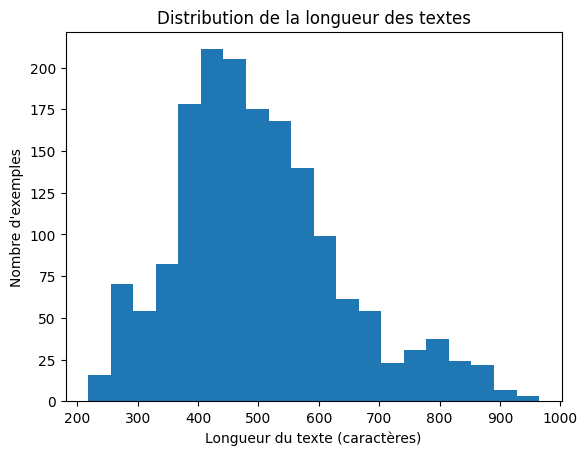

In [8]:
# %% [markdown]
# Étude du dataset onurSakar/GYM-Exercise
#
# Ce notebook analyse le format et le contenu du dataset disponible sur Hugging Face.

# %%
# 1) Installation et imports
%pip install -q datasets matplotlib

from datasets import load_dataset
import matplotlib.pyplot as plt

# %%
# 2) Chargement du dataset
# Afficher les splits et le split 'train'
ds = load_dataset("onurSakar/GYM-Exercise")
print(ds)
train = ds['train']
print("\nColonnes du split 'train' :", train.column_names)
print("Nombre d'exemples :", len(train))

# %%
# 3) Exploration visuelle de quelques exemples
print("\n5 premiers exemples :")
for i, ex in enumerate(train.select(range(5)), 1):
    print(f"--- Exemple {i} ---")
    print(ex['text'], "\n")

# %%
# 4) Distribution de la longueur des textes (en caractères)
lengths = [len(t) for t in train['text']]
plt.hist(lengths, bins=20)
plt.xlabel("Longueur du texte (caractères)")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution de la longueur des textes")
plt.show()


In [9]:
# %%
# 5) Préparation des données pour le fine-tuning
from transformers import MT5Tokenizer
from datasets import DatasetDict

tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
max_input_length, max_target_length = 128, 64

def split_and_tokenize(example):
    text = example["text"]
    # Séparer instruction et réponse
    if "[/INST]" in text:
        instr, resp = text.split("[/INST]", 1)
    else:
        instr, resp = text, ""
    # Nettoyage des balises
    instr = instr.replace("<s>[INST] <<SYS>>", "").replace("<</SYS>>", "").strip()
    resp = resp.replace("</s>", "").strip()
    # Préparer input et target
    input_enc = tokenizer(instr, max_length=max_input_length, truncation=True, padding="max_length")
    target_enc = tokenizer(resp, max_length=max_target_length, truncation=True, padding="max_length")
    return {
        "input_ids": input_enc["input_ids"],
        "attention_mask": input_enc["attention_mask"],
        "labels": target_enc["input_ids"],
    }

# Appliquer sur train/validation
split = train.train_test_split(train_size=500, test_size=100, seed=42)
datasets_tok = DatasetDict({
    "train": split["train"].map(split_and_tokenize, batched=False, remove_columns=["text"]),
    "validation": split["test"].map(split_and_tokenize, batched=False, remove_columns=["text"]),
})
print(datasets_tok)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
Map: 100%|██████████| 100/100 [00:00<00:00, 1635.09 examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})


In [10]:
# %%
# 6) Fine-tuning du modèle
from transformers import MT5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import torch

# Charger le modèle
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Arguments d'entraînement
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=False,  # désactivé pour la stabilité
    learning_rate=1e-4,
    weight_decay=0.01,
    predict_with_generate=True,
    do_eval=True,
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)

trainer.train()



OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 379.81 MiB is free. Including non-PyTorch memory, this process has 5.41 GiB memory in use. Of the allocated memory 5.13 GiB is allocated by PyTorch, and 141.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# %%
# 7) Inférence : exemples de génération
prompts = [
    "Explique l'exercice Bench Press pour cibler les pectoraux. Type: Strength, équipement: Barbell.",
    "Décris l'exercice Squat pour les quadriceps. Type: Strength, équipement: Bodyweight.",
]

for prompt in prompts:
    # Préparation des entrées
    input_enc = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    # Génération
    gen_ids = model.generate(
        input_enc.input_ids,
        attention_mask=input_enc.attention_mask,
        max_length=64,
        num_beams=4,
        early_stopping=True
    )
    # Affichage
    output = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
    print(f"Prompt : {prompt}
Réponse : {output}
")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1660
    })
})
Colonnes du split 'train': ['text']
Nombre d'exemples : 1660
--- Exemple 1 ---
  <s>[INST] <<SYS>> Below is an instruction that describes a task. Write a response that appropriately completes the request <</SYS>> Is it possible to build muscle while losing weight? [/INST]Yes, it's possible but challenging. Focus on a slight calorie deficit, prioritize protein intake, and incorporate strength training. Accept that muscle gains may be slower during weight loss phases. </s>

--- Exemple 2 ---
  <s>[INST] <<SYS>> Below is an instruction that describes a task. Write a response that appropriately completes the request <</SYS>> What are some strategies for managing and reducing the impact of environmental stressors, such as pollution or noise? [/INST]1. Install noise-r

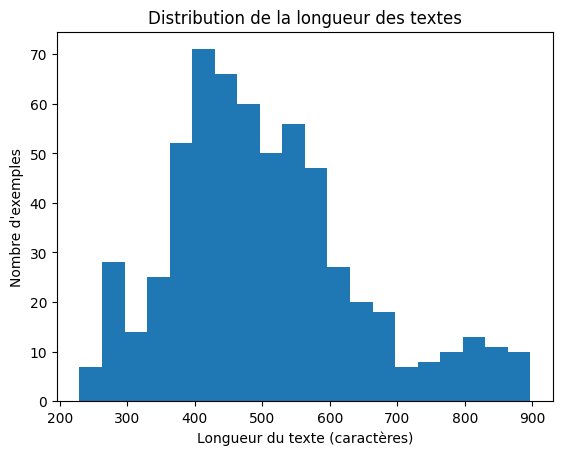

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 500
}) Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})


OutOfMemoryError: CUDA out of memory. Tried to allocate 246.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 61.81 MiB is free. Including non-PyTorch memory, this process has 5.72 GiB memory in use. Of the allocated memory 5.47 GiB is allocated by PyTorch, and 115.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
# %% [markdown]
# Chatbot Coach Sportif en Français avec mT5-small (batch_size=4, 8-bit)
#
# Ce notebook présente le fine-tuning de **google/mt5-small** sur le dataset **onurSakar/GYM-Exercise**.
# Configuré pour un GPU RTX 3060 Laptop (6 Go VRAM) avec quantification 8-bits et offload automatique.

# %%
# 1) Installation et imports
%pip install -q transformers datasets evaluate accelerate bitsandbytes
%pip install -q -U bitsandbytes accelerate transformers datasets evaluate


from datasets import load_dataset, DatasetDict
from transformers import (
    MT5Tokenizer,
    MT5ForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
import torch
import numpy as np

# %%
# 2) Chargement et exploration du dataset
# Charger le split 'train'
ds_full = load_dataset("onurSakar/GYM-Exercise")
print(ds_full)
train_full = ds_full['train']
print("Colonnes du split 'train':", train_full.column_names)
print("Nombre d'exemples :", len(train_full))
# Afficher 5 exemples bruts
for i, ex in enumerate(train_full.select(range(5))):
    print(f"--- Exemple {i+1} ---\n{ex['text']}\n")

# %%
# 3) Sous-échantillonnage et découpe train/validation
raw = train_full.shuffle(seed=42).select(range(600))
split = raw.train_test_split(train_size=500, test_size=100, seed=42)
datasets = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
})
print(datasets)

# %%
# 4) Distribution de la longueur des textes (en caractères)
import matplotlib.pyplot as plt
lengths = [len(t) for t in raw['text']]
plt.hist(lengths, bins=20)
plt.xlabel("Longueur du texte (caractères)")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution de la longueur des textes")
plt.show()

# %%
# 5) Préparation des données pour le fine-tuning
# Tokenizer
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
max_input_length, max_target_length = 128, 64

def split_and_tokenize(example):
    text = example["text"]
    if "[/INST]" in text:
        instr, resp = text.split("[/INST]", 1)
    else:
        instr, resp = text, ""
    instr = instr.replace("<s>[INST] <<SYS>>", "").replace("<</SYS>>", "").strip()
    resp = resp.replace("</s>", "").strip()
    input_enc = tokenizer(instr, max_length=max_input_length, truncation=True, padding="max_length")
    target_enc = tokenizer(resp, max_length=max_target_length, truncation=True, padding="max_length")
    return {
        "input_ids": input_enc["input_ids"],
        "attention_mask": input_enc["attention_mask"],
        "labels": target_enc["input_ids"],
    }

# Appliquer mapping
train_tok = datasets['train'].map(split_and_tokenize, batched=False, remove_columns=["text"])
val_tok   = datasets['validation'].map(split_and_tokenize, batched=False, remove_columns=["text"])
# Format PyTorch
train_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
val_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
print(train_tok, val_tok)

# %%
# 6) Fine‑tuning du modèle en 8-bits
# Charger le modèle en 8-bit avec offload
# 6) Fine-tuning du modèle en float16 avec offload automatique
model = MT5ForConditionalGeneration.from_pretrained(
    "google/mt5-small",
    torch_dtype=torch.float16,
    device_map="auto"
)
trainer_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-sportif-small-fp16",
    num_train_epochs=3,
    per_device_train_batch_size=2,      # batch réduit
    per_device_eval_batch_size=2,
    fp16=True,                          # précision mixte
    gradient_checkpointing=True,        # économise de la VRAM
    learning_rate=1e-4,
    weight_decay=0.01,
    predict_with_generate=True,
    do_eval=True,
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
)
trainer.train()


# %%
# 7) Inférence : exemples de génération
prompts = [
    "Explique l'exercice Bench Press pour cibler les pectoraux. Type: Strength, équipement: Barbell.",
    "Décris l'exercice Squat pour les quadriceps. Type: Strength, équipement: Bodyweight.",
]
for prompt in prompts:
    input_enc = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    gen_ids = model.generate(
        input_enc.input_ids,
        attention_mask=input_enc.attention_mask,
        max_length=64,
        num_beams=4,
        early_stopping=True
    )
    output = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
    print(f"Prompt : {prompt}\nRéponse : {output}\n")


In [2]:
# 1) Dépendances
%pip install -q -U transformers datasets accelerate bitsandbytes peft sentencepiece

from datasets         import load_dataset
from transformers     import (AutoTokenizer, AutoModelForSeq2SeqLM,
                               DataCollatorForSeq2Seq, Seq2SeqTrainer,
                               Seq2SeqTrainingArguments, BitsAndBytesConfig)
from peft             import LoraConfig, get_peft_model, TaskType
import torch, random

MODEL_NAME = "google/mt5-small"          # reste multilangue
MAX_IN, MAX_OUT = 128, 64

# 2) Dataset (identique à votre notebook, mais réduit pour l'exemple)
raw_ds  = load_dataset("onurSakar/GYM-Exercise", split="train")
raw_ds  = raw_ds.shuffle(seed=42).select(range(600))
splits  = raw_ds.train_test_split(train_size=500, seed=42)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(ex):
    txt = ex["text"]
    if "[/INST]" in txt:
        instr, resp = txt.split("[/INST]", 1)
    else:
        instr, resp = txt, ""
    instr = instr.replace("<s>[INST] <<SYS>>", "").replace("<</SYS>>", "").strip()
    resp  = resp.replace("</s>", "").strip()
    model_in  = tokenizer(instr, max_length=MAX_IN,  truncation=True, padding="max_length")
    model_out = tokenizer(resp,  max_length=MAX_OUT, truncation=True, padding="max_length")
    model_in["labels"] = model_out["input_ids"]
    return model_in

train_ds = splits["train"].map(preprocess, remove_columns=["text"])
val_ds   = splits["test"] .map(preprocess, remove_columns=["text"])
train_ds.set_format(type="torch")
val_ds.set_format(type="torch")

# 3) Quantisation 4-bits + ajout des adaptateurs LoRA
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit            = True,
    bnb_4bit_quant_type     = "nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype  = torch.float16,
)

base_model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    quantization_config = bnb_cfg,
    device_map          = "auto"        # garde l'offload
)

lora_cfg = LoraConfig(
    r                = 8,
    lora_alpha       = 32,
    lora_dropout     = 0.05,
    bias             = "none",
    task_type        = TaskType.SEQ_2_SEQ_LM,
    target_modules   = ["q", "v", "k", "o"]  # proj. de T5
)

model = get_peft_model(base_model, lora_cfg)
model.print_trainable_parameters()  # ≈ 5 M params seulement

# 4) Entraînement
training_args = Seq2SeqTrainingArguments(
    output_dir                   = "./mt5-gym-lora",
    num_train_epochs             = 3,
    per_device_train_batch_size  = 1,
    gradient_accumulation_steps  = 16,   # => batch effectif de 16
    learning_rate                = 2e-4,
    fp16                         = True,
    logging_steps                = 10,
    save_steps                   = 200,
    optim                        = "paged_adamw_32bit",  # mémoire CPU
    report_to                    = "none",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model            = model,
    args             = training_args,
    train_dataset    = train_ds,
    eval_dataset     = val_ds,
    data_collator    = data_collator,
)

trainer.train()


Note: you may need to restart the kernel to use updated packages.


/home/maxime/DataDevIA/chatbotcoach_project/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


RuntimeError: 
🚨 Forgot to compile the bitsandbytes library? 🚨
1. You're not using the package but checked-out the source code
2. You MUST compile from source

Attempted to use bitsandbytes native library functionality but it's not available.

This typically happens when:
1. bitsandbytes doesn't ship with a pre-compiled binary for your CUDA version
2. The library wasn't compiled properly during installation from source

To make bitsandbytes work, the compiled library version MUST exactly match the linked CUDA version.
If your CUDA version doesn't have a pre-compiled binary, you MUST compile from source.

You have two options:
1. COMPILE FROM SOURCE (required if no binary exists):
   https://huggingface.co/docs/bitsandbytes/main/en/installation#cuda-compile
2. Use BNB_CUDA_VERSION to specify a DIFFERENT CUDA version from the detected one, which is installed on your machine and matching an available pre-compiled version listed above

Original error: Configured CUDA binary not found at /home/maxime/DataDevIA/chatbotcoach_project/.venv/lib/python3.12/site-packages/bitsandbytes/libbitsandbytes_cuda118.so

🔍 Run this command for detailed diagnostics:
python -m bitsandbytes

If you've tried everything and still have issues:
1. Include ALL version info (operating system, bitsandbytes, pytorch, cuda, python)
2. Describe what you've tried in detail
3. Open an issue with this information:
   https://github.com/bitsandbytes-foundation/bitsandbytes/issues

Native code method attempted to call: lib.cquantize_blockwise_fp16_nf4()

In [ ]:
python - << EOF
import bitsandbytes as bnb
print("GPU support disponible :", bnb.cuda.is_available())
EOF
